### **Universidade Federal do Rio Grande do Norte - UFRN**

### **Programa de Pós Graduação em Engenharia Elétrica e de Computação - PPgEEC**

### PPGEEC 2327 - Tópicos Especiais em Processamento Inteligente da Informação

#### Docente: Tiago Tavares Leite Barros

#### Discente: Matheus Gomes Diniz Andrade


# Importing

In [332]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from typing import List, Tuple, Optional

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


In [333]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Aquisição dos Dados

https://www.kaggle.com/datasets/manjeetsingh/retaildataset?select=Features+data+set.csv

In [334]:
data = pd.read_csv('../data/retail.csv')
data["Date"] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

data = data.sort_values(by="Date").reset_index()

data.head()

,index,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,2730,16,2010-02-05,19.79,2.580,NaN,NaN,NaN,NaN,NaN,189.381697,7.039,False
2,5460,31,2010-02-05,39.05,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
3,3640,21,2010-02-05,39.05,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
4,4550,26,2010-02-05,9.55,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,8.488,False


In [335]:
data = data.groupby("Date").agg({"Fuel_Price": "mean"})

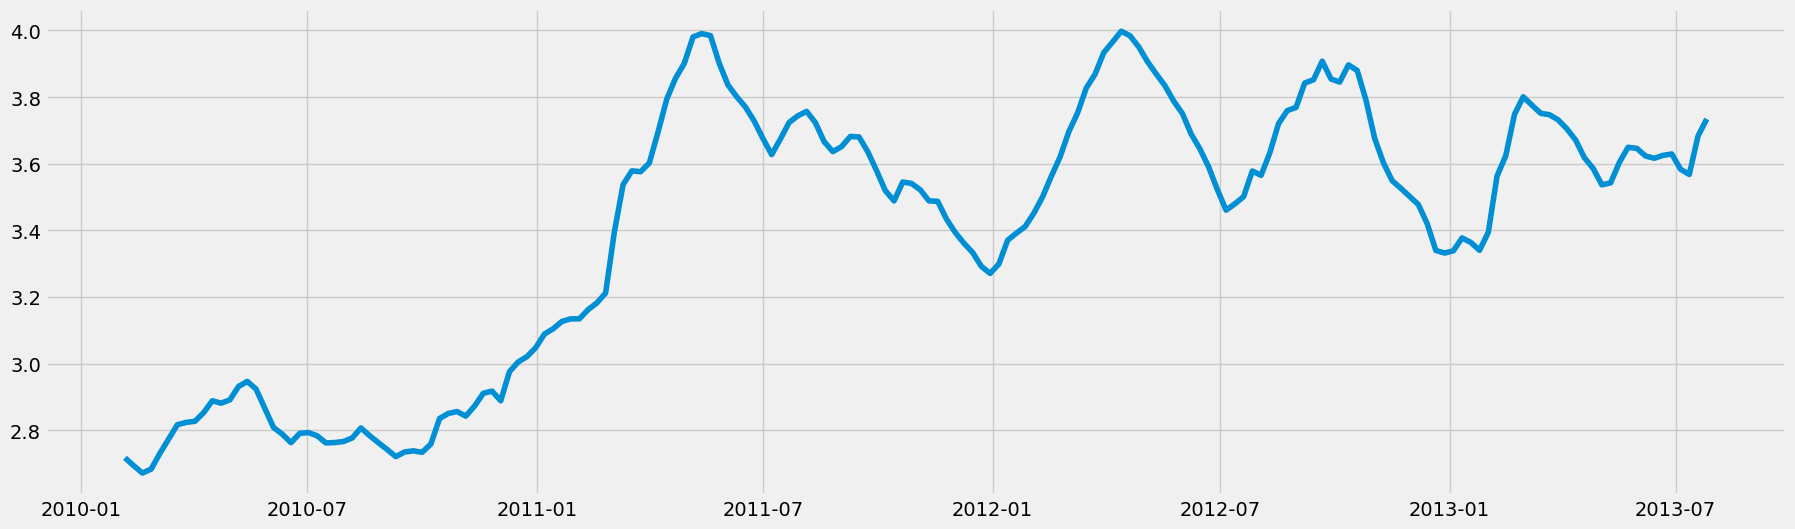

In [336]:
plt.figure(figsize=(20, 6))

plt.plot(data["Fuel_Price"])

plt.show()

## Testes de Estacionariedade

### Dickey-Fuller Aumentado

- $H_0$: A série não é estacionária (possui raiz unitária)
- $H_1$: A série é estacionária (não possui raiz unitária)


In [337]:
resultado = adfuller(data["Fuel_Price"])

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente não é estacionária.')
else:
    print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente é estacionária.')


O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


### KPSS

- $H_0$: A série temporal é estacionária em torno de uma constante
- $H_1$: A série temporal possui uma raiz unitária

In [338]:
resultado = kpss(data["Fuel_Price"])

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).')
    print('A série temporal provavelmente é estacionária.')
else:
    print('\nO valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).')
    print('A série temporal provavelmente não é estacionária.')


O valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).
A série temporal provavelmente não é estacionária.


# Tendência

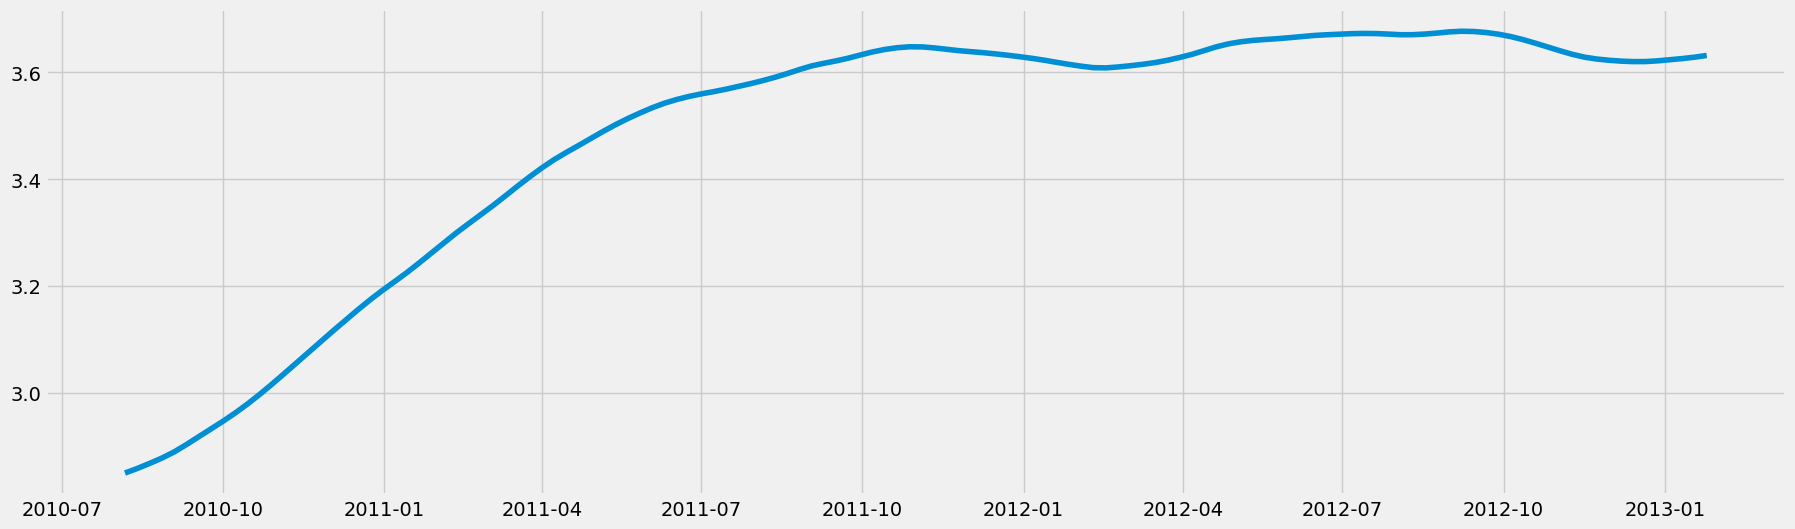

In [339]:
decompose = seasonal_decompose(data["Fuel_Price"], model='aditive', period=52)

plt.figure(figsize=(20, 6))
plt.plot(decompose.trend)
plt.show()

# Dependência

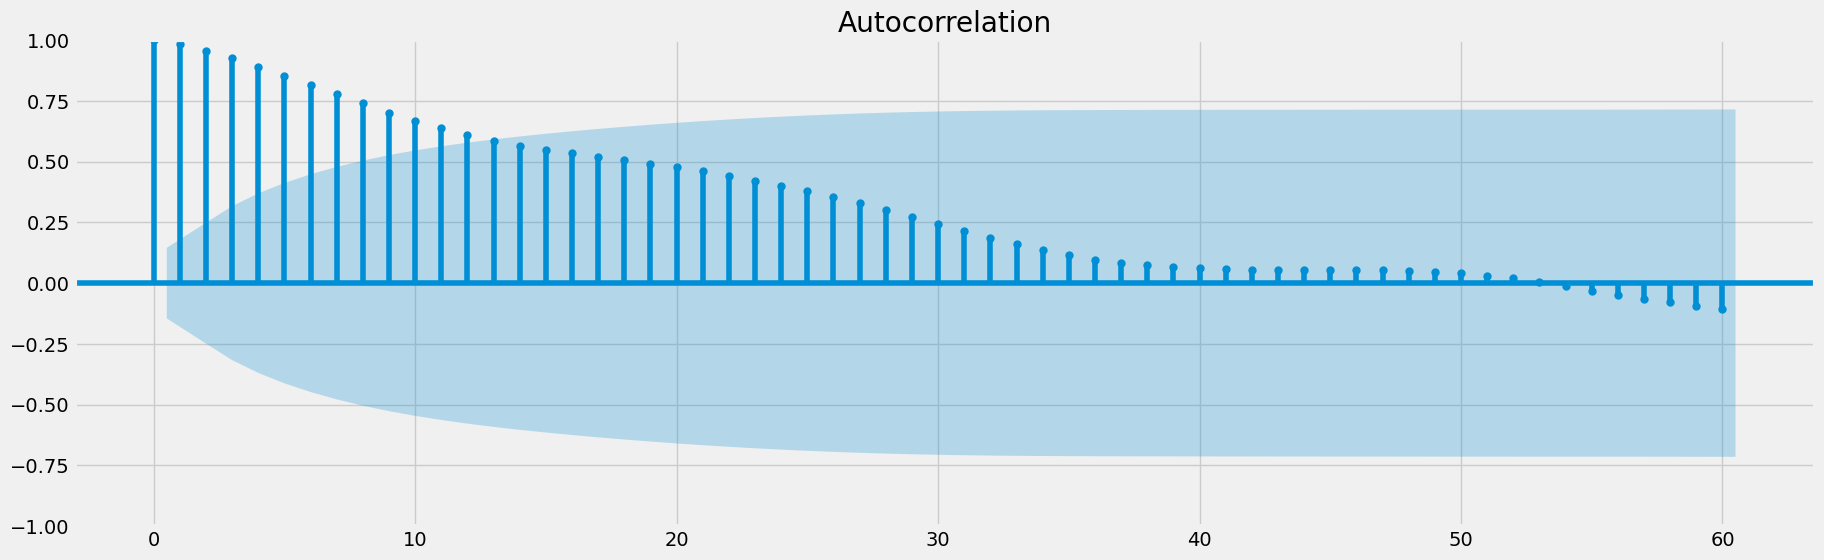

In [340]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_acf(data["Fuel_Price"], lags=60, ax=ax)

plt.show()

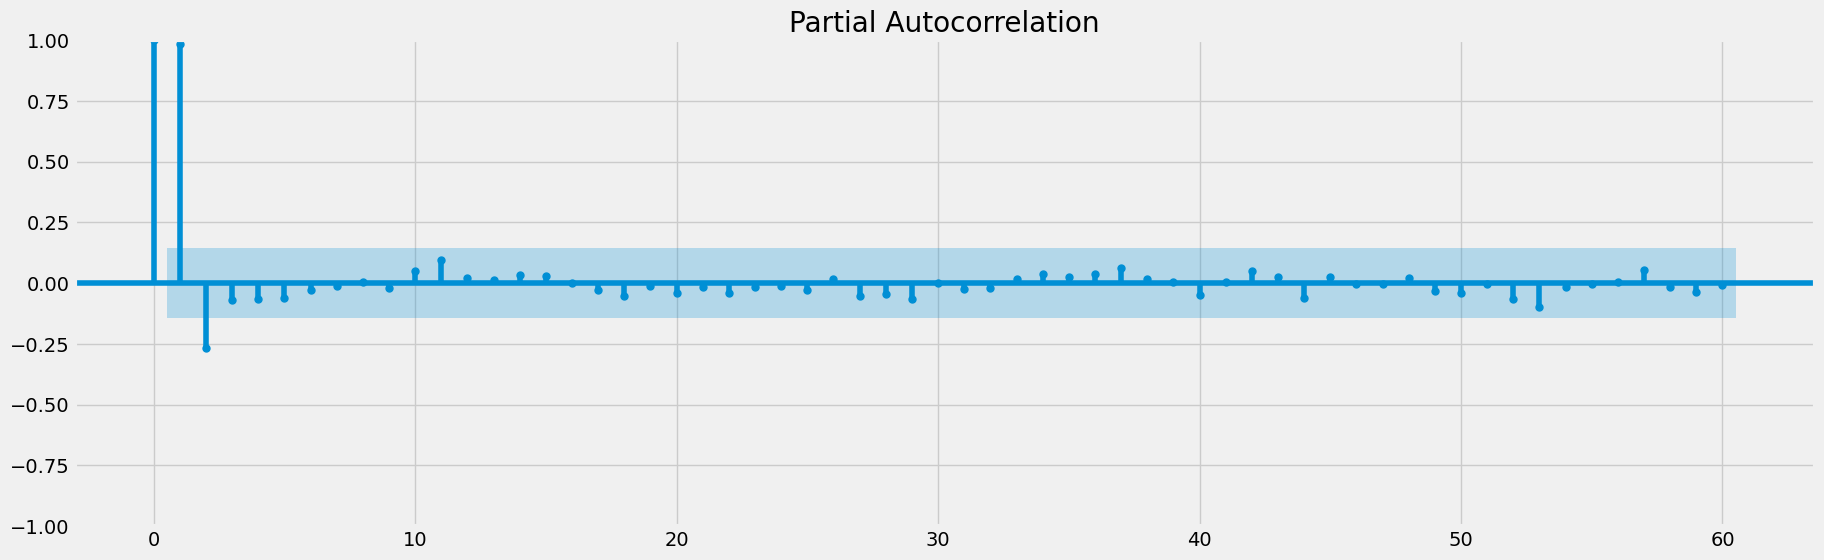

In [341]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_pacf(data["Fuel_Price"], lags=60, ax=ax)

plt.show()

### Pré-Processamento

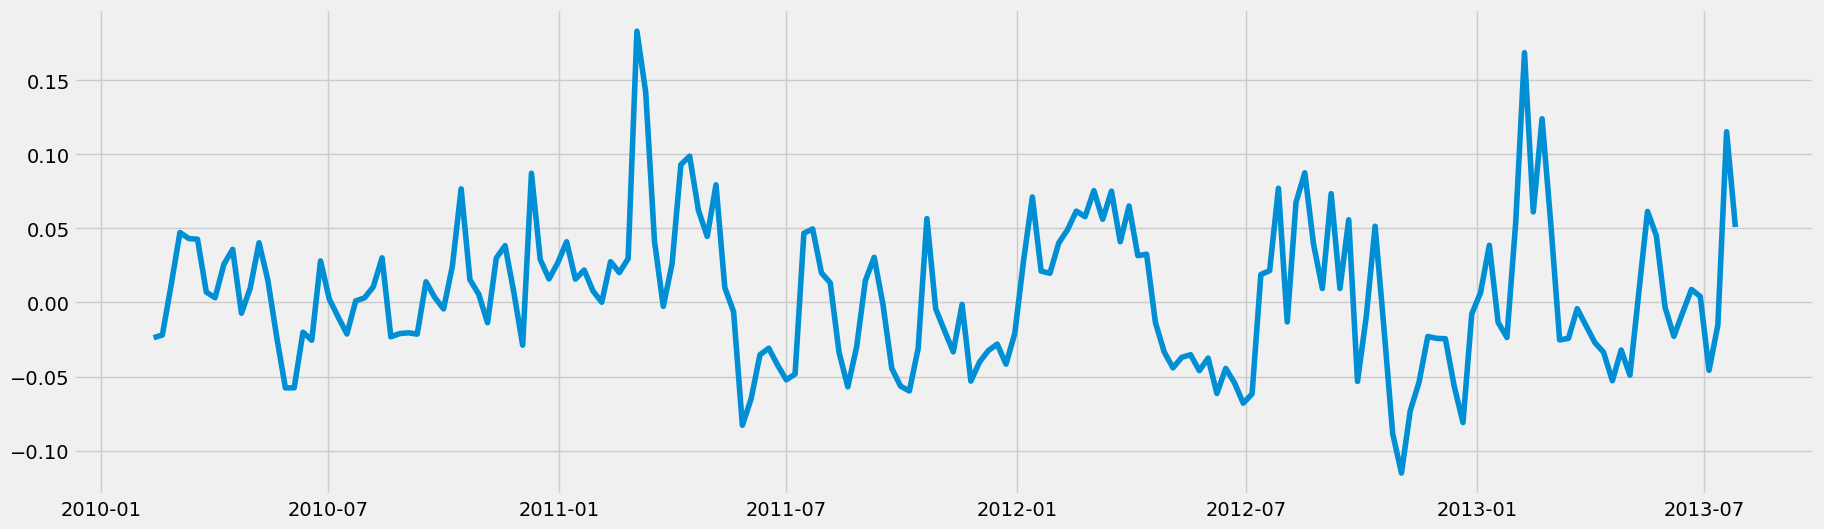

In [342]:
data_diff = data["Fuel_Price"].diff().dropna()

plt.figure(figsize=(20, 6))

plt.plot(data_diff)

plt.show()

In [343]:
resultado = adfuller(data_diff)

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente não é estacionária.')
else:
    print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente é estacionária.')


O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [344]:
resultado = kpss(data_diff)

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).')
    print('A série temporal provavelmente é estacionária.')
else:
    print('\nO valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).')
    print('A série temporal provavelmente não é estacionária.')


O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).
A série temporal provavelmente é estacionária.


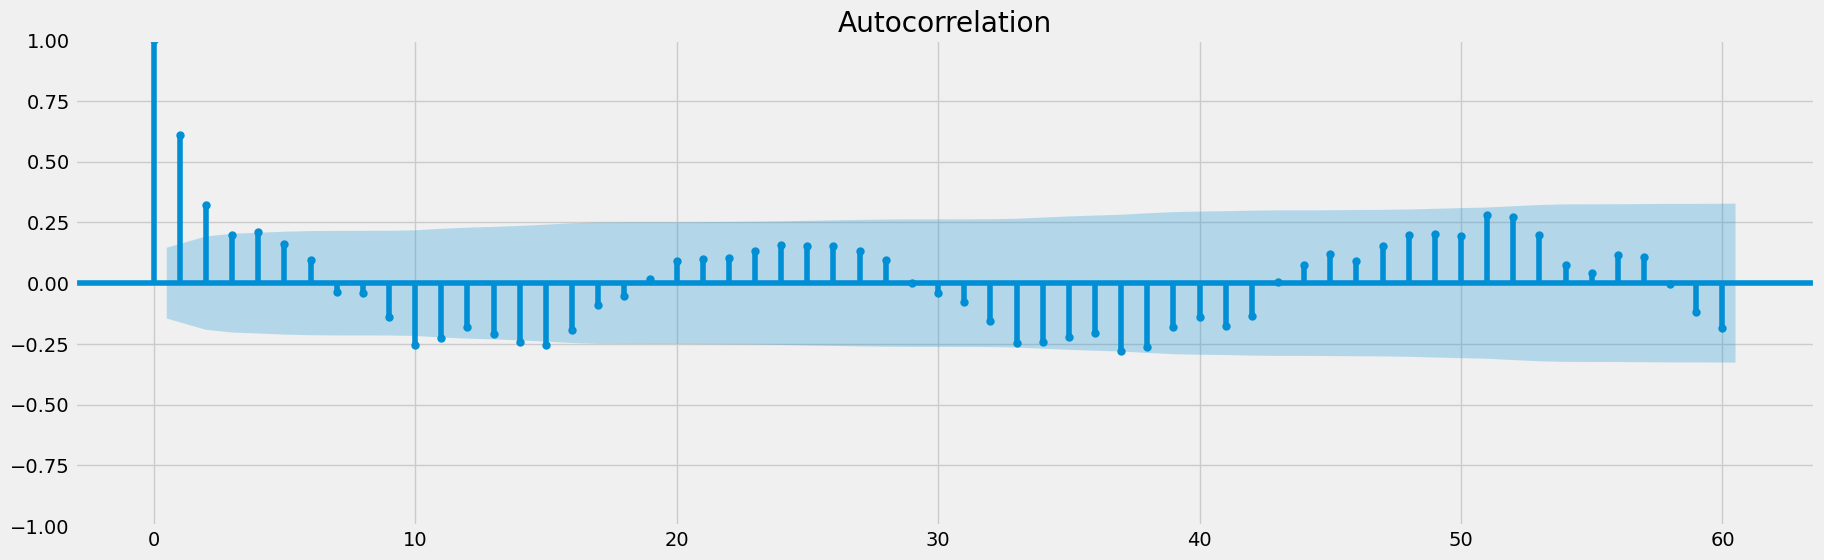

In [345]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_acf(data_diff, lags=60, ax=ax)
plt.show()

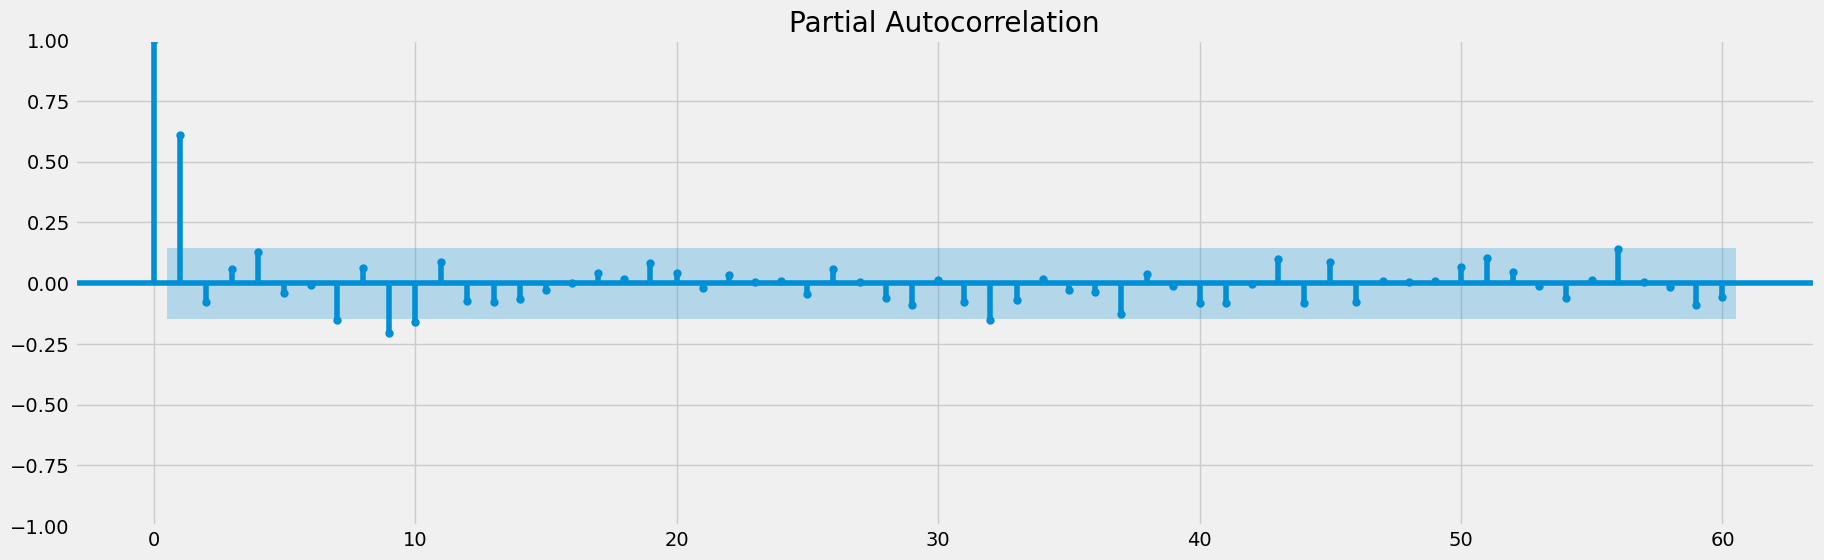

In [346]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_pacf(data_diff, lags=60, ax=ax)

plt.show()

# Funções Auxiliares

In [ ]:
def forecast(
    endog: pd.Series,
    train_size: int,
    horizon: int,
    order: Tuple[int, int, int],
    exog: Optional[pd.DataFrame] = None
):
    train_endog = endog.iloc[:train_size]
    train_exog = exog.iloc[:train_size] if exog is not None else None

    model = SARIMAX(train_endog, exog=train_exog, order=order)
    res = model.fit(disp=False)
    
    start_index = train_size
    end_index = train_size + horizon - 1
    
    exog_forecast = exog.iloc[start_index : end_index + 1] if exog is not None else None
    
    predictions = res.get_prediction(start=start_index, end=end_index, exog=exog_forecast)
    
    oos_pred = predictions.predicted_mean
    
    return oos_pred

def rolling_forecast(
    endog: pd.Series,
    train_size: int,
    horizon: int,
    window: int,
    order: Tuple[int, int, int],
    exog: Optional[pd.DataFrame] = None
) -> list:
    total_size = train_size + horizon
    pred = []

    for i in range(train_size, total_size, window):
        current_endog = endog.iloc[:i]
        current_exog = exog.iloc[:i] if exog is not None else None
        
        model = SARIMAX(current_endog, exog=current_exog, order=order)
        res = model.fit(disp=False)
    
        exog_forecast = exog.iloc[i : i + window] if exog is not None else None
        
        oos_pred = res.forecast(steps=window, exog=exog_forecast)
        
        pred.extend(oos_pred)

    return pred

In [348]:
results = pd.DataFrame({
    "MAE": [],
    "RMSE": [],
    "MAPE": [],
    "R2": []
})

# AR($p$)

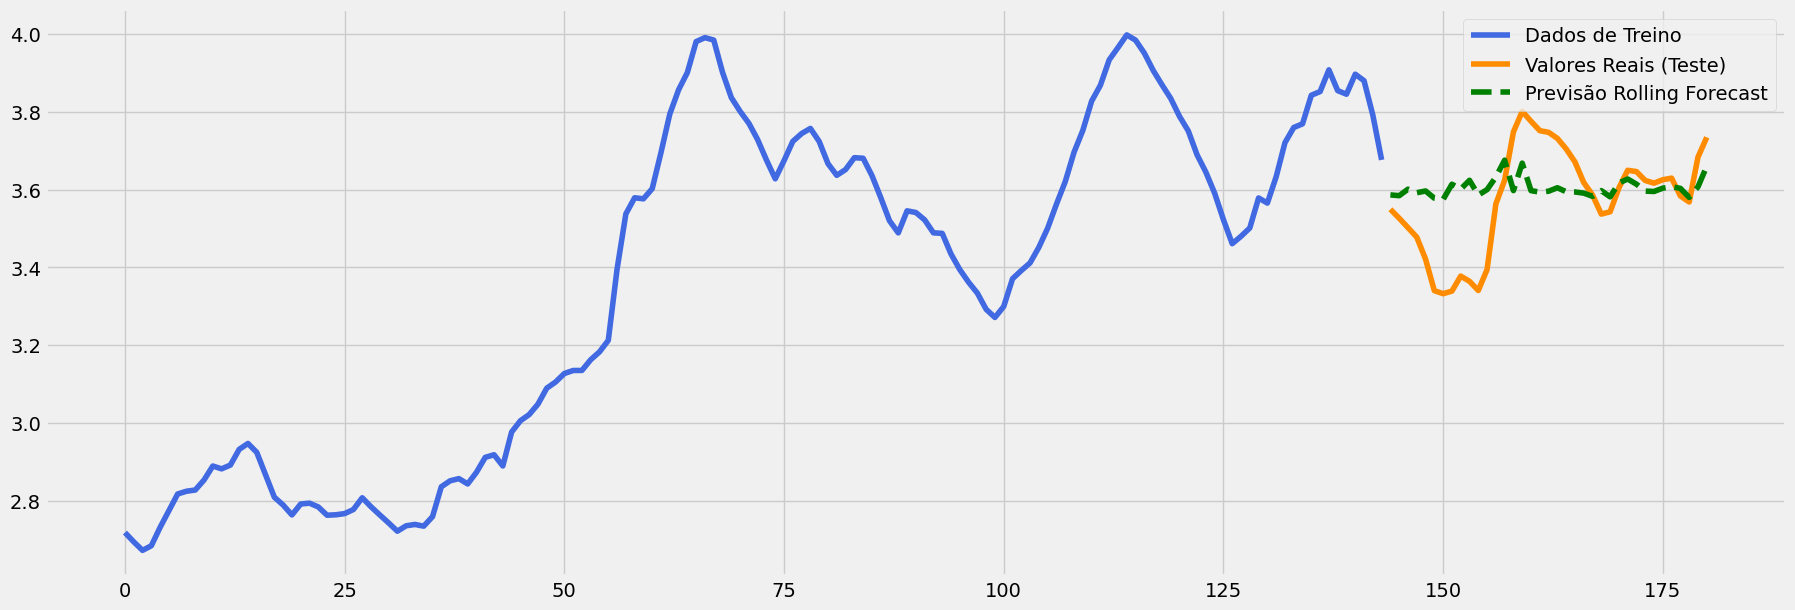

In [349]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, (0, 0, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(20, 7))

x_axis_train = range(len(train))

start = len(train)
end = start + len(test)
x_axis_test = range(start, end)

x_axis_pred = range(start, start + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["AR(1) - Rolling"])
])

plt.plot(x_axis_train, train, label='Dados de Treino', color='royalblue')
plt.plot(x_axis_test, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(x_axis_pred, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

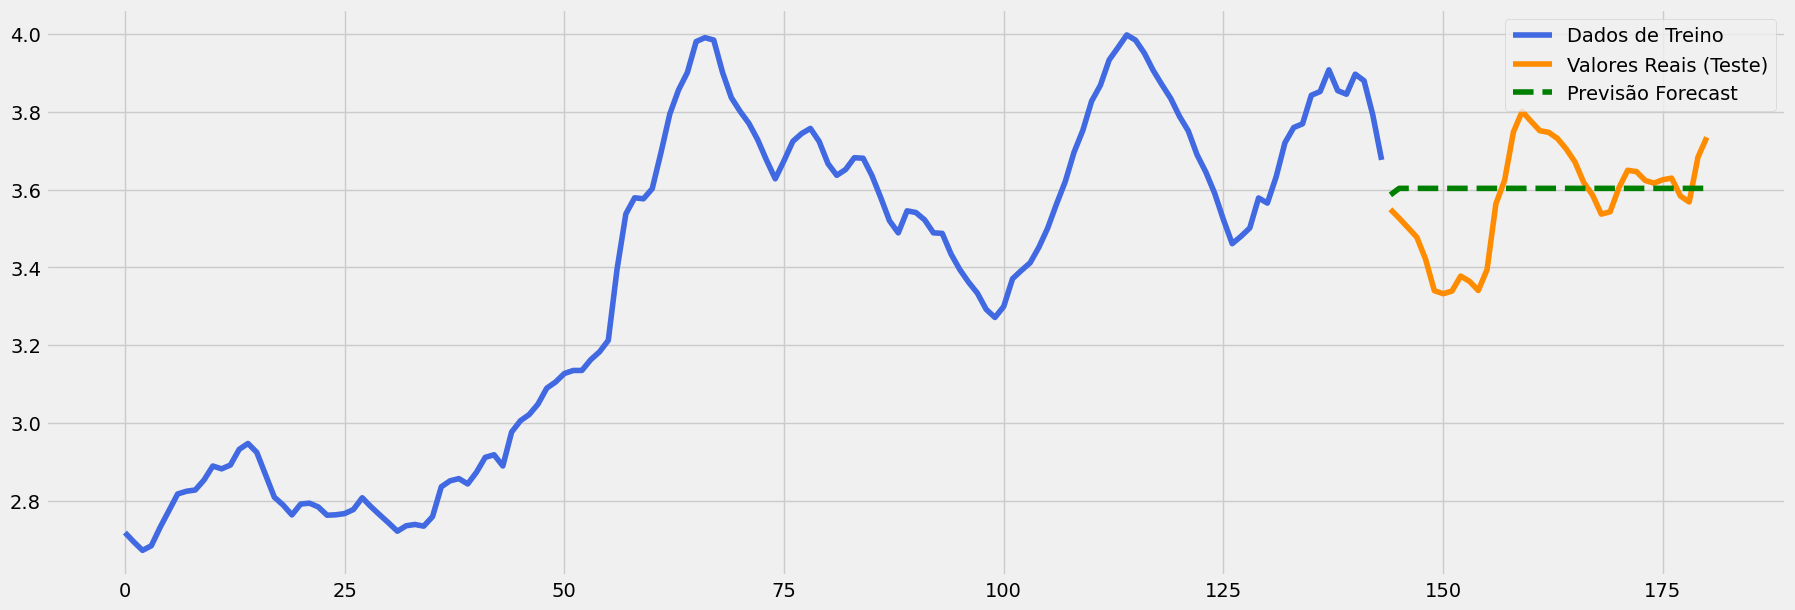

In [350]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = forecast(data_diff, TRAIN_LEN, HORIZON, (0, 0, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(20, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["AR(1)"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

# MA($q$)

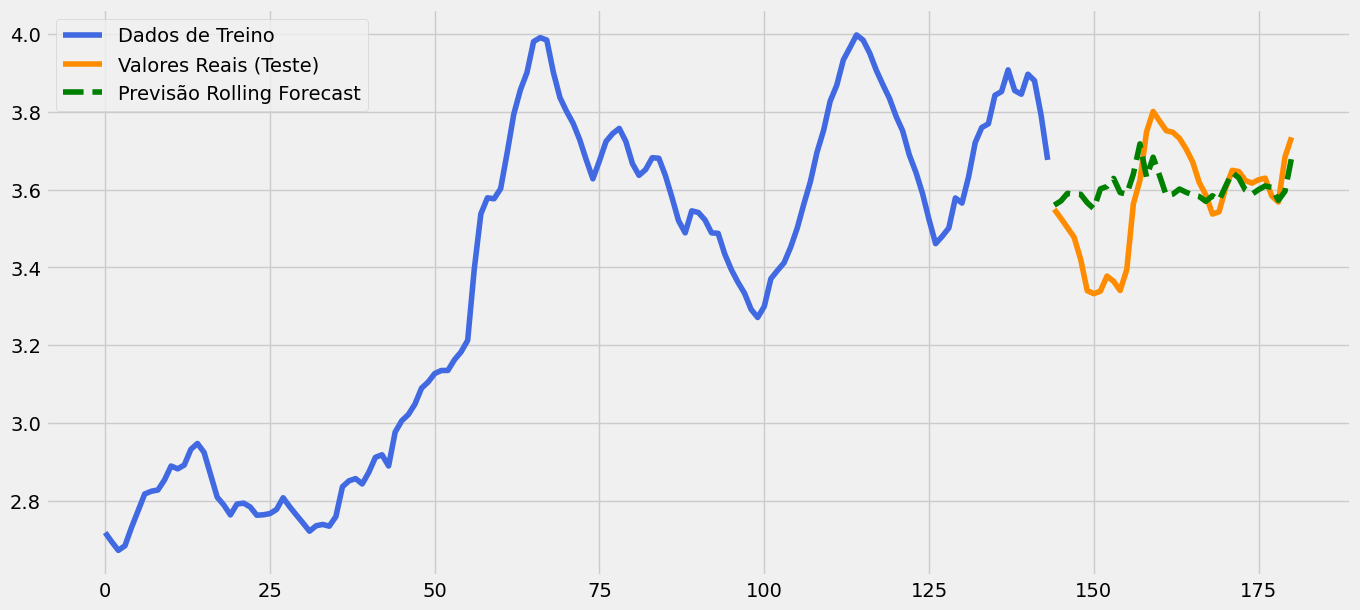

In [351]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, order=(2, 0, 0))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["MA(2) - Rolling"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

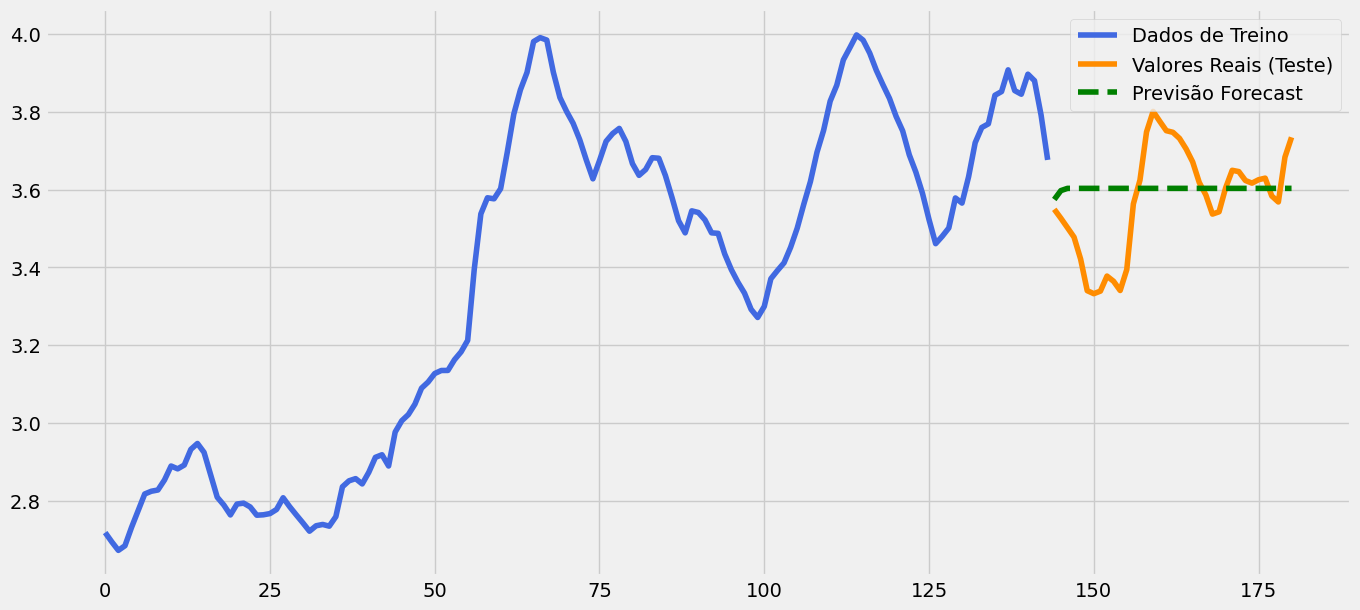

In [352]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = forecast(data_diff, TRAIN_LEN, HORIZON, (0, 0, 2))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["MA(2)"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

# ARMA ($p$, $q$)

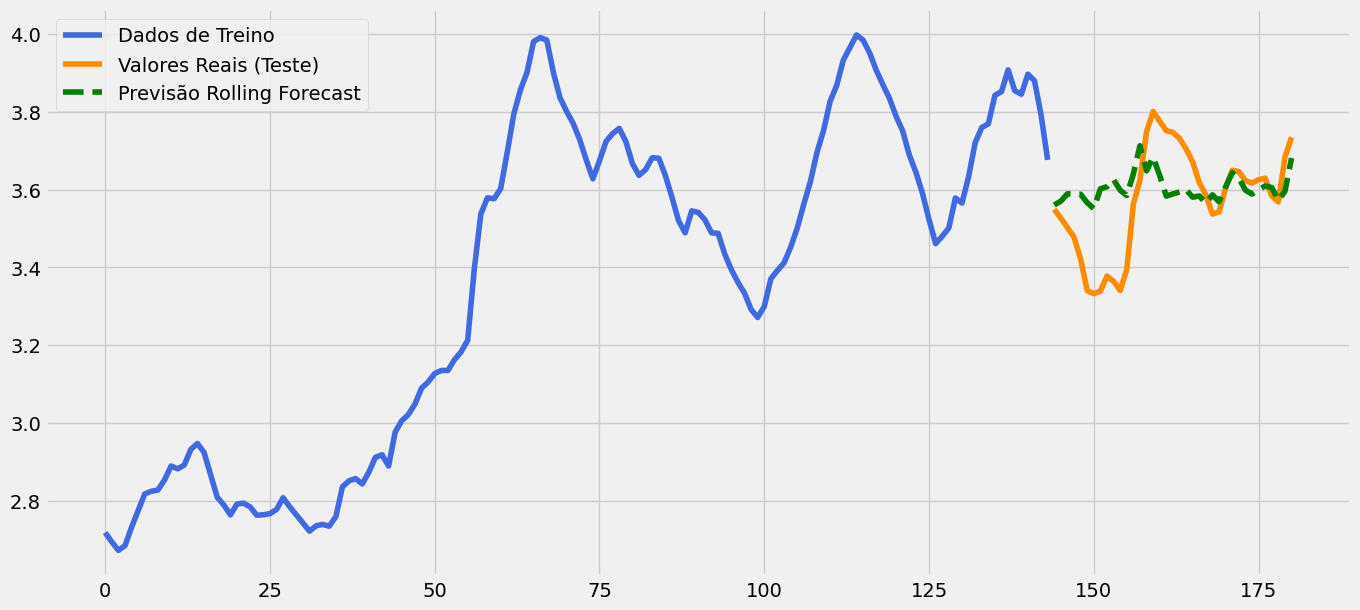

In [353]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, order=(2, 0, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARMA(1, 2) - Rolling"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

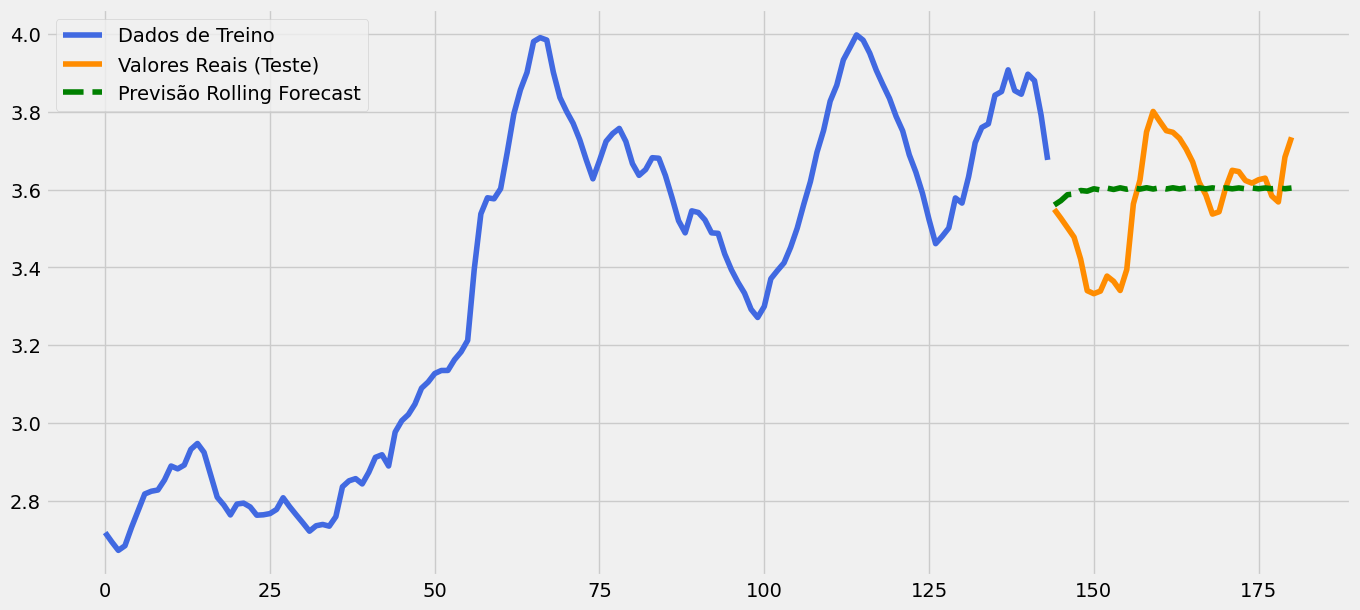

In [354]:
train = data_diff[:int(0.8 * len(data_diff))]
test = data_diff[int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = forecast(data_diff, TRAIN_LEN, HORIZON, (2, 0, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

train = data["Fuel_Price"].iloc[:TRAIN_LEN]
test = data["Fuel_Price"].iloc[TRAIN_LEN + 1:]
pred = data["Fuel_Price"].iloc[TRAIN_LEN] + pred

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARMA(1, 2)"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

# ARIMA ($p$, $d$, $q$)

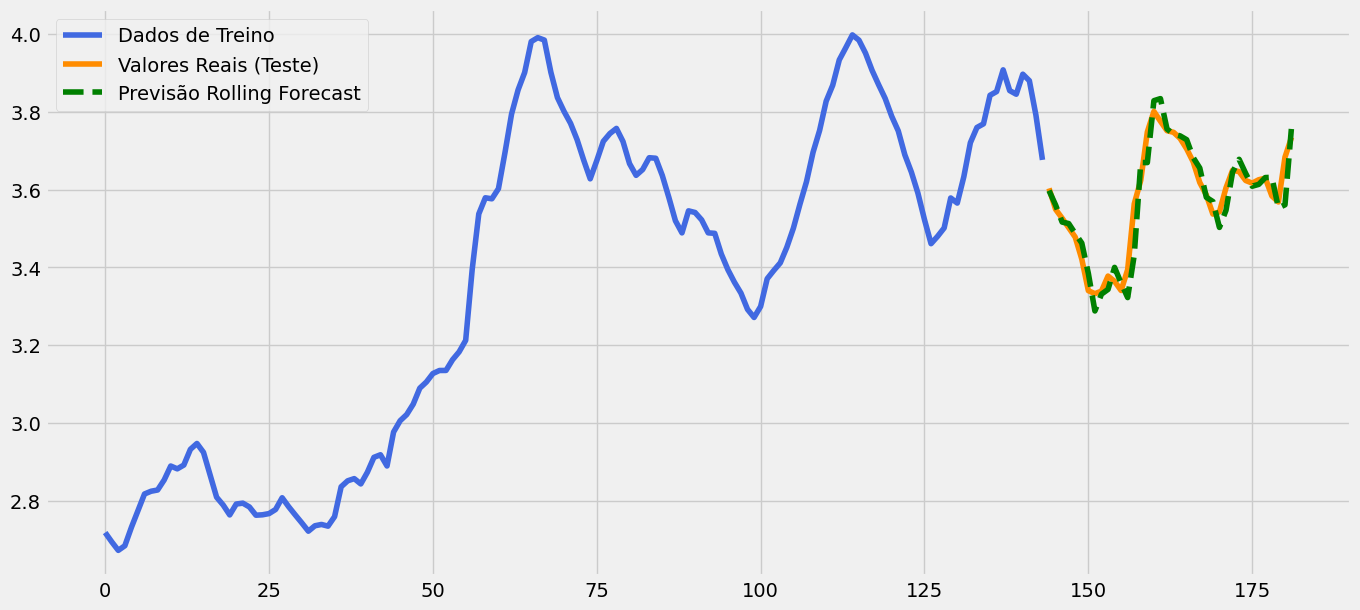

In [355]:
train = data["Fuel_Price"][:int(0.8 * len(data_diff))]
test = data["Fuel_Price"][int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = rolling_forecast(data["Fuel_Price"], TRAIN_LEN, HORIZON, WINDOW, (2, 1, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARIMA(1, 1, 2) - Rolling"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

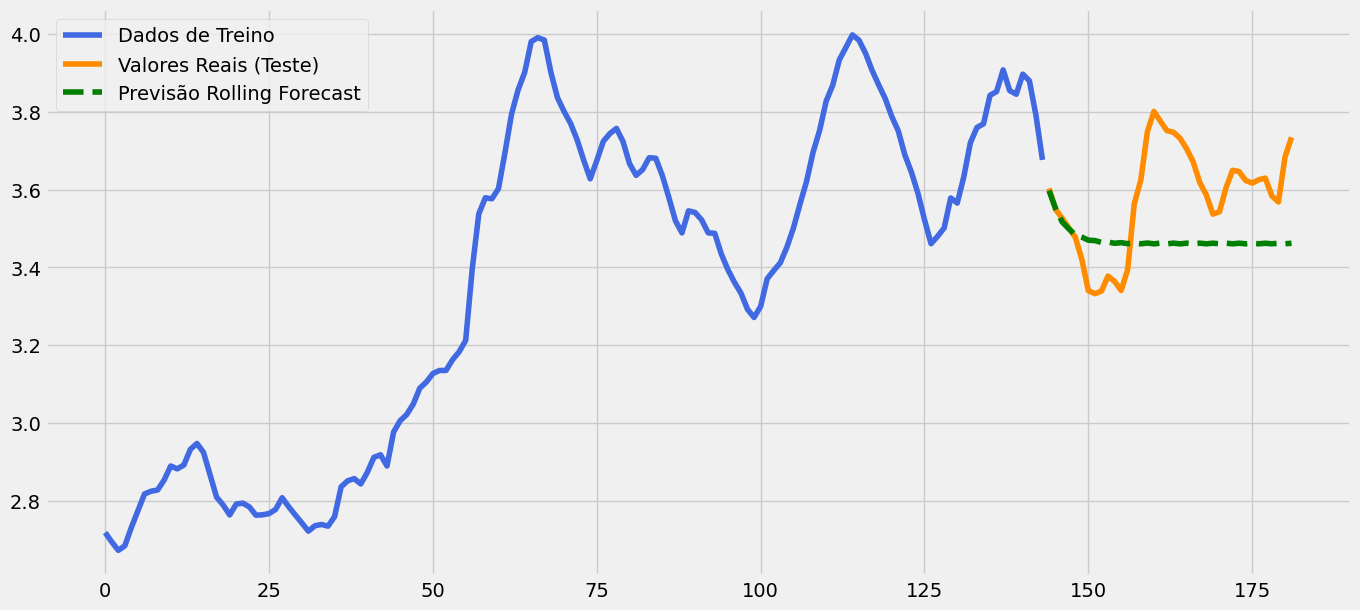

In [356]:
train = data["Fuel_Price"][:int(0.8 * len(data_diff))]
test = data["Fuel_Price"][int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = forecast(data["Fuel_Price"], TRAIN_LEN, HORIZON, (2, 1, 1))

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARIMA(1, 1, 2)"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

# ARIMAX ($p$, $d$, $q$)

In [357]:
data = pd.read_csv('../data/retail.csv')
data["Date"] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

data = data.sort_values(by="Date").reset_index()

data = data.groupby("Date").agg({"Fuel_Price": "mean", "Temperature": "mean"})

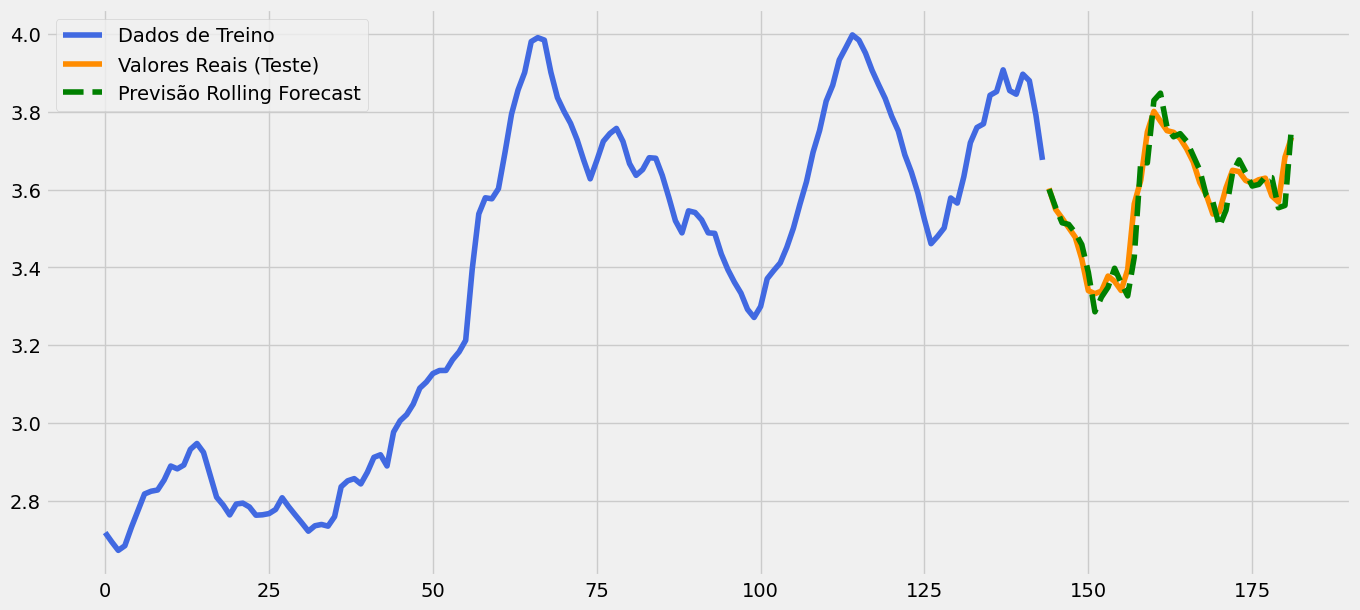

In [358]:
train = data["Fuel_Price"][:int(0.8 * len(data_diff))]
test = data["Fuel_Price"][int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = rolling_forecast(data["Fuel_Price"], TRAIN_LEN, HORIZON, WINDOW, (2, 1, 1), data["Temperature"])

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARIMAX(1, 1, 2) - Rolling"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

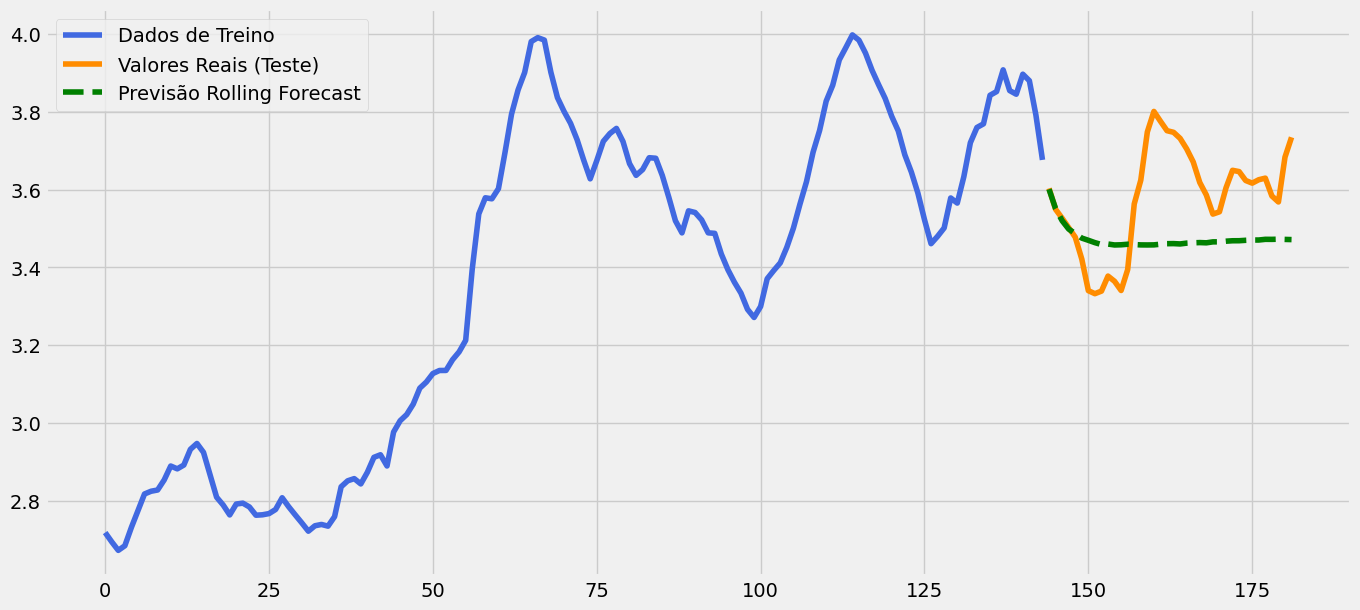

In [359]:
train = data["Fuel_Price"][:int(0.8 * len(data_diff))]
test = data["Fuel_Price"][int(0.8 * len(data_diff)):]

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

data_pred = test.copy()

pred = forecast(data["Fuel_Price"], TRAIN_LEN, HORIZON, (2, 1, 1), data["Temperature"])

pred_series = pd.Series(pred)

plt.figure(figsize=(15, 7))

eixo_x_treino = range(len(train))

inicio_teste = len(train)
fim_teste = inicio_teste + len(test)
eixo_x_teste = range(inicio_teste, fim_teste)

eixo_x_previsao = range(inicio_teste, inicio_teste + len(pred))

results = pd.concat([
    results,
    pd.DataFrame({
        "MAE": mean_absolute_error(test, pred),
        "RMSE": mean_squared_error(test, pred),
        "MAPE": mean_absolute_percentage_error(test, pred),
        "R2": r2_score(test, pred)
    }, index=["ARIMAX(1, 1, 2)"])
])

plt.plot(eixo_x_treino, train, label='Dados de Treino', color='royalblue')
plt.plot(eixo_x_teste, test, label='Valores Reais (Teste)', color='darkorange')
plt.plot(eixo_x_previsao, pred, label='Previsão Rolling Forecast', color='green', linestyle='--')

plt.legend()
plt.show()

# Comparativo

In [360]:
results

,MAE,RMSE,MAPE,R2
AR(1) - Rolling,0.104084,0.017638,0.029628,0.041270
AR(1),0.108702,0.019064,0.030919,-0.036263
MA(2) - Rolling,0.099669,0.016545,0.028390,0.100676
MA(2),0.108227,0.019021,0.030785,-0.033927
"ARMA(1, 2) - Rolling",0.099236,0.016462,0.028274,0.105203
"ARMA(1, 2)",0.105741,0.018493,0.030071,-0.005217
"ARIMA(1, 1, 2) - Rolling",0.031573,0.001893,0.008847,0.894417
"ARIMA(1, 1, 2)",0.149520,0.030663,0.041189,-0.710051
"ARIMAX(1, 1, 2) - Rolling",0.032144,0.001965,0.008996,0.890423
"ARIMAX(1, 1, 2)",0.146136,0.029762,0.040236,-0.659770
